# **Data Loading**

In [33]:
!apt -qq -y install fonts-nanum > /dev/null

In [34]:
!pip install tomotopy &> /dev/null # "& > /dev/null" install 결과 표시 숨김
!pip install konlpy &> /dev/null

In [35]:
!git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git &> /dev/null
!bash Mecab-ko-for-Google-Colab/install_mecab-ko_on_colab190912.sh &> /dev/null

In [2]:
import pandas as pd
import numpy as np

import tomotopy as tp
import pprint

import collections
import gensim
from konlpy.tag import Mecab
from konlpy.corpus import kolaw

import matplotlib.pyplot as plt
import matplotlib.colors as clr

import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=15)
plt.rc('font', family='NanumBarunGothic') 
fm._rebuild()

%matplotlib inline 

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
df = pd.read_csv("/content/drive/MyDrive/소셜빅데이터분석_2021/W12_b_LDA 시각화/df_sample.csv", encoding='UTF-8') #여기에 적합한 데이터 경로를 지정해서 돌리기 바랍니다. 저장된 결과물이 없어지는 것을 방지하기 위해 데이터는 본 폴더에 넣지 않았습니다.  
df.head()                                                                    #지난주 데이터를 가져다 쓰면 됩니다.      

,year,month,day,content,group
0,2013,9,2,한·일 두 정부의 외면으로 묻혀질 뻔했던 간토(關東)대지진 조선인 대학살이 오늘날 ...,Kyunghyang
1,2012,6,10,"2009년 77일간의 공장 점거농성과 강경진압, 소속 노동자의 37인 2646명 대...",Hankyoreh
2,2009,8,13,자유는 만물의 생명이요 평화인생의 행복이다 자유와 평화정신을 설파하고 실천한 만해 ...,Chosun
3,2018,8,30,지난해 스위스 제네바에서 열린 유엔 인권이사회 총회 뉴스 유엔기구가 지난 1년간 북...,Joongang
4,2002,10,12,노벨 평화상 수상자로 결정된 지미 카터는 퇴임 후의 행적이 더욱 아름다운 대통령으로...,Joongang


# Tokenizer
Mecab 품사 태그 : https://docs.google.com/spreadsheets/d/1-9blXKjtjeKZqsf4NzHeYJCrr49-nXeRF6D80udfcwY/edit#gid=589544265

In [5]:
mecab = Mecab()
tags = ['NNG', 'NNP']
stopwords = []

def Tokenizer(text):
    morphs = mecab.pos(text)
    pos = []

    for word, tag in morphs:
        if(len(word) < 2 and word not in stopwords): 
            continue
        if tag in tags:
            pos.append(word)

    return pos

# **Topic Coherence**

토픽 모델링을 구현할 때 토픽 개수에 따른 일관성 확인을 위한 검증 단계   
perplexity와 coherence 값을 비교하여 적절한 토픽값을 유추함   
* perplexity는 낮을수록, coherence는 높을수록 일반적으로 우수하다고 평가함
* 그러나 일반적으로 두 조건을 모두 충족하는 값을 찾는 경우는 거의 없음
* 토픽모델링은 파라미터 설정에 따라 얼마든지 값이 바뀌기 때문에 토픽 개수에서 정답은 없음(참고용으로만 활용해야 함)
* 이를 위해서는 토픽 모델링 이전의 전처리 단계를 꼼꼼하게 진행할 필요 있음

현재 tomotopy에서는 topic coherence를 확인할 수 있는 방법이 없음.   
따라서 tomotopy에서 실행한 lda 결과를 gensim의 자료구조 형태로 변환하여 topic coherence를 비교하는 절차를 거침

https://radimrehurek.com/gensim/models/coherencemodel.html

In [6]:
# tomotopy의 lda 결과를 gensim에서 활용가능한 자료구조 형태로 변환하는 함수

def get_coherence(model, coherence=None, topn=None, processes=None): # None으로 하면 자동으로 default...밑에서 값을 정해 줬으니, 정해진 값이 들어온다
    """
    model: tomotopy lda
    coherence: coherence 값을 구하는 알고리즘(u_mass 나 c_v 를 사용하는데 일반적으로 c_v 활용)
    topn: coherence 계산할 때 고려할 토픽 키워드
    processes: workers와 유사한 기능
    """

    # tomotopy 에서 토픽-키워드간 데이터 추출
    topics = []
    for k in range(model.k): #model.k에서 뽑는게 숫자이기 때문에 레인지를 쓴다...k에 해당되는 내용이 없고
        word_probs = model.get_topic_words(k, topn) #토픽에 해당되는 키워드에 대해 확률값을 넣어주는 것
        topics.append([word for word, prob in word_probs])
    
    # tomotopy에서 토픽-문서간 데이터 추출하여 gensim에서 활용가능한 코퍼스 구현
    texts = []
    corpus = []
    for doc in model.docs: #여긴 왜 range를 안넣나?...실제 문서의 내용을 가져와야 하기 때문에...리스트 형태로 있는 문서의 내용을 가져온다...doc는 내용이 있다...
        words = [model.vocabs[token_id] for token_id in doc.words] #doc.words가 어디서 왔나? '토모토피에서 자동적으로 정해 놓은 변수이다' 
        texts.append(words) #젠심 단계에서 lda를 하기 위한 신문기사...토모토미에서 해놓은 것은 되돌리는 것....
        freqs = list(collections.Counter(doc.words).items()) #왜 .items()가 붙은거지? collections.Counter는 반드시 젠심은 아니다...collectios 라이브러리에서...items() 함수는 튜플(x=y...검찰=100)...전체를 list형태로..
                  #list를 통해서 각각 문서들에 대해서 진행함.....list는 전체를 하나의 집합으로 묶어 준다...
        corpus.append(freqs)
    
    # gensim 형태의 자료구조 형태로 변환
    id2word = dict(enumerate(model.vocabs)) #model.vocabs는 변수 아닌가? enumerate는 전체 문서에서 특정 단어가 언급된 숫자를 말한다...전체 오천개에서 검찰=1500번 이런 식으로....dict는 튜플형태로??
    dictionary = gensim.corpora.dictionary.Dictionary.from_corpus(corpus, id2word) # tomotopy에 활용된 키워드들을 (단어, 빈도) 구조의 형태로 변환
    
    cm = gensim.models.coherencemodel.CoherenceModel(
        topics=topics,
        texts=texts,
        corpus=corpus,
        dictionary=dictionary,  
        coherence=coherence, # (바로 아래에 있는 'c_v', 10, 5를 넣는 것임...)
        topn=topn,
        processes=processes,
    )

    return cm.get_coherence() #그냥 cm을 리턴하는게 아니고 여기에 또 .get_coherence()를 넣는것? 왜?; 이건 리턴했는데, 아래에서 전혀 사용되지 않네? return을 안하면 해당하는 값을 가져오지 않는다..cm은 속성값이 나온다...

In [7]:
# perplexity, coherence 값을 확인하는 함수

def compute_coherence_values(start, limit, step):
    for i in range(start, limit, step):
        mdl = tp.LDAModel(k=i)
        for text in df['content']:  
            mdl.add_doc(Tokenizer(text))  
        mdl.train(iter=50, workers=0)
        coherence_value = get_coherence(mdl, coherence='c_v', topn=10, processes=5)

        print('Topic: {}\tLog-likelihood: {}\tPerplexity: {}\tCoherence: {}'\
        .format(
            i,
            mdl.ll_per_word,
            mdl.perplexity,
            coherence_value
            )
        )
        coherence_values.append(coherence_value) 
        perplexities.append(mdl.perplexity) 

In [8]:
limit = 100 # maximum topic number
start = 10; # minimum topic number
step = 10; # step unit

coherence_values = []
perplexities = []

# coherence 확인은 gensim의 프로세싱을 따르기 때문에 시간이 상당히 소요됨
compute_coherence_values(start, limit, step)

Topic: 10	Log-likelihood: -8.800790941762234	Perplexity: 6639.493382625125	Coherence: 0.5196873079094115
Topic: 20	Log-likelihood: -8.75803001634301	Perplexity: 6361.5670426766355	Coherence: 0.5546966931611481
Topic: 30	Log-likelihood: -8.75651999130943	Perplexity: 6351.968166285145	Coherence: 0.5556040224063643
Topic: 40	Log-likelihood: -8.747624867901168	Perplexity: 6295.717176206116	Coherence: 0.5920553947816123
Topic: 50	Log-likelihood: -8.747639692734168	Perplexity: 6295.810509853696	Coherence: 0.5793037240858574
Topic: 60	Log-likelihood: -8.75171676404061	Perplexity: 6321.531375507115	Coherence: 0.5852165280885208
Topic: 70	Log-likelihood: -8.762165194603805	Perplexity: 6387.927721906647	Coherence: 0.5713067270948734
Topic: 80	Log-likelihood: -8.756251252735256	Perplexity: 6350.261376767299	Coherence: 0.5866032754066426
Topic: 90	Log-likelihood: -8.751566225101215	Perplexity: 6320.579810504078	Coherence: 0.577466572382548


In [9]:
x = range(start, limit, step)

mdl_check = pd.DataFrame(list(zip(x, perplexities, coherence_values)), columns=['Num Topics', 'Perplexity', 'Coherence']) # from np.array ro pd.dataframe

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fb201f9ff10>,
      dtype=object)

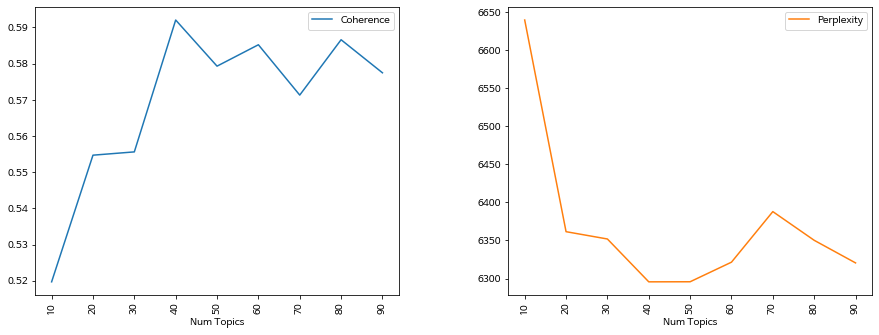

In [10]:
fig, ax = plt.subplots(figsize=(15,5), nrows=1, ncols=2) # nrows=1 ? ncols=2?..2개 그림 배치를 어떻게?....행1개 열2개...subplots이 쪼개는 것....fig는 figsize에 관한 것....15.5가 아래 눈에 보이는 사이즈.....(가로..세로)

plt.subplots_adjust(left=0.125, #여백 간의 관계를 adjust.... 그림이 여려개 있을때 공간과 여백 설정....left=.125...반으로 쪼갠 것 내에서 배치를 어떻게...wspace는 두 그림 사이의 거리...hspace는 필요가 없다...
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.3, 
                    hspace=0.5)

pd.pivot_table(mdl_check, values=["Perplexity", "Coherence"],index="Num Topics")\
    .plot(kind='line', rot=90, ax=ax, subplots=True)  # perplexity와 coherence의 위치? \표시는 .plot 과 연결. .plot을 어떻게 그릴거냐? 선 그래프...rotation 가로축 로테이션..위의 ax.
                                                      # subplots=True는 두개를 나눈다....
                                                      # \.plot??. 아래 상단에 나오는 array....는 뭐지? 없애도 되지 않나?

In [11]:
# 위 그래프를 확인한 후 k에 적절한 토픽값 입력(여기서는 그냥 임의로 10을 넣음)

mdl = tp.LDAModel(k=10)
perplexity = []

for text in df['content']:
    mdl.add_doc(Tokenizer(text))

for i in range(10):
    mdl.train(iter=10, workers=0)
    perplexity.append(mdl.perplexity) # 위에서는 토픽 개수에 따른 perplexity 여기서는 iteration에 따른 perplexity

# mdl.train(iter=100, workers=0)

# 10개의 토픽을 구성하는 키워드 제시
for k in range(mdl.k):
    print('Top 10 words of topic #{}'.format(k))
    print(mdl.get_topic_words(k, top_n=10))

Top 10 words of topic #0
[('서울', 0.00852977205067873), ('기자', 0.008153163827955723), ('인권', 0.007735840976238251), ('병원', 0.007237089332193136), ('사람', 0.006717980839312077), ('오후', 0.006025835406035185), ('정신', 0.0056899418123066425), ('시민', 0.005618691444396973), ('사건', 0.005425298120826483), ('경찰', 0.005354047752916813)]
Top 10 words of topic #1
[('대통령', 0.025839146226644516), ('의원', 0.020192047581076622), ('후보', 0.016903575509786606), ('정치', 0.015285799279808998), ('국민', 0.01302544679492712), ('대표', 0.01160422246903181), ('위원장', 0.01071973703801632), ('정부', 0.010190557688474655), ('개혁', 0.00901880394667387), ('선거', 0.008512303233146667)]
Top 10 words of topic #2
[('학생', 0.02670917473733425), ('학교', 0.020748136565089226), ('교육', 0.019491594284772873), ('인권', 0.015179138630628586), ('아이', 0.011298933997750282), ('교사', 0.009469407610595226), ('영화', 0.007991713471710682), ('청소년', 0.007941451855003834), ('여성', 0.0072377873584628105), ('문제', 0.006333076395094395)]
Top 10 words of topic #

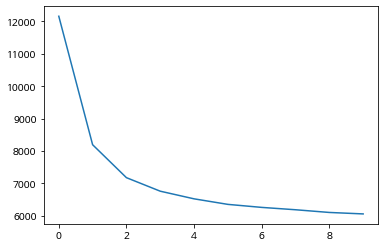

In [12]:
plt.plot(perplexity)
plt.show()

# **Look inside deeply**

In [13]:
pprint.pprint(mdl.get_topic_words(8, top_n=10))

[('수사', 0.014703743159770966),
 ('사건', 0.014474168419837952),
 ('인권', 0.013987689279019833),
 ('검찰', 0.013927563093602657),
 ('경찰', 0.013840106315910816),
 ('조사', 0.009664040058851242),
 ('헌법', 0.008395914919674397),
 ('국가', 0.007898503914475441),
 ('침해', 0.006849021650850773),
 ('법원', 0.006537456531077623)]


In [14]:
top_docs = [[] for _ in range(10)] # 관련이 높은 문서들을 아래의 리스트(꺽쇠) 안에 넣어준다.......루프 만드는 방식이 두개 있는데...1. for방식의 루프...2. 이러한 방식의 루프(nested list).....

In [15]:
top_docs = [[] for _ in range(mdl.k)] # 문서와 토픽간의 연관성을 보여주는 변수가 필요하다..변수를 넣어줄 공간 만듦...첫번째 토픽과 연관성이 높은 문서를 넣어줄 공간...빈꺽쇠는 빈공간... - 아무것도 없는 빈공간을 넣어준다..
                                        # -는 아무것도 안받은거구...이것을 꺽쇠에 넣어주니 결과적으로 꺽쇠에는 아무것도 안들어간다.....이건 nested list라 불리임! 

for doc in mdl.docs:
    top_docs[doc.get_topics(top_n=1)[0][0]].append(doc) # 전체 document에 대해 최우선 토픽 번호를 매칭 (토픽값은 아니고 토픽값만 가져온다...)

In [16]:
# print(mdl.docs[0].get_topics(top_n=1)[0]) # 0번째 document에서 가장 높은 비중을 차지하는 토픽과 토픽값 확인....top_n=1도 함수다! 제일 토픽값이 높은 것을 가져와라....토픽값이 제일 높은 토픽을 가져와서 퓨플형태로...
                                            # top_n=3 [0] 이렇게 하면....높은 3개를 가져오는데 그 중에서 0번째를 가져오라....[0] [0] 토픽 변호만 나오고..[0] [1]을 하면 토픽값이 나온다.... 
# print(mdl.docs[0].get_topics(top_n=1)[0][0]) 토픽 번호만 추출

In [17]:
for k in range(mdl.k):
    print('Num docs belonging to topic #%d: %d' % (k, len(top_docs[k]))) # %d 정규식인데....%자리에 무엇을 넣어주겠다...% 뒤에 세팅을 해준다....top_docs로 나온 문서들의 숫자를 넣어준다.....

Num docs belonging to topic #0: 353
Num docs belonging to topic #1: 523
Num docs belonging to topic #2: 446
Num docs belonging to topic #3: 901
Num docs belonging to topic #4: 101
Num docs belonging to topic #5: 542
Num docs belonging to topic #6: 456
Num docs belonging to topic #7: 456
Num docs belonging to topic #8: 960
Num docs belonging to topic #9: 262


In [18]:
top_docs[8][0:9]

[<tomotopy.Document with words="재판 출석 이명박 대통령 사진 동취 재단 이명박 정부 경찰 노무현 대통령 동향 파악 청와대 국가 정보원 좌파 판사 인사 불이익 이명박 정부 국정 운영 비판 사람 좌파 정황 문건 재판 공개 서울 중앙 지법 형사 재판장 정계선 대통령 재판 서울시 서초구 영포 빌딩 압수 대통령 기록물 증거 조사 영포 빌딩 대통령 설립 청계 재단 소유 빌딩 검찰 압수수색 과정 대통령 기록물 발견 대통령 대통령 기록물 무단 파기 유출 은닉 혐의 대통령 기록물 관리 법률 위반 재판 이날 검찰 공개 문건 대통령 경찰 대통령 뒷조사 내용 청와대 검찰 노무현 대통령 개설 정치 사이트 관련 여론 경찰청 문건 최근 동정 내용 대통령 골프 내용 대통령 상황 지속 봉하 마을 노건평 소문 지속 확인 국정원 시국 사건 전향 판결 판사 편향 판사 인사 불이익 응징 검토 문건 다수 공개 법원 편향 실태 조치 고려 방안 문건 화물 연대 파업 편향 판결 사례 언급 국정원 연구회 시국 사건 좌파 입장 옹호 여론 조성 다각도 압박 활동 전개 최근 법원 편향 쇄신 분위기 역류 조짐 선제 대처 문건 법원 행정 처장 직간접 통로 좌파 세력 우려 전달 보수 언론 맞대응 유도 좌파 판사 한직 배정 이익 배출 방안 지속 검토 좌파 사법부 편향 실태 조치 고려 대책 연구회 활동 편향 판사 법원 인사 불이익 압박 예비 법조인 좌파 차단 로스쿨 이념 성향 모니터링 검찰 법원 진출 차단 내용 이명박 정부 정부 비판 언론 언론인 좌파 언론 탄압 검토 편향 방송인 차단 공정 방송 풍토 조성 문건 문제 프로그램 폐지 정화 추진 활개 공정 방송 기조 경영진 대상 방송 건전화 전개 봄철 프로그램 인사 개편 계기 핵심 인물 척결 대책 좌파 방송 사법 처리 편파 방송 근절 문건 좌파 방송인 사법 처리 검경 수뇌부 공조 강화 방송 통신 위원회 개편 검토 문건 이외 민변 좌파 지원 활동 강화 실태 대응 방안 좌파 변호사 집단 소송 관련 국세청 국방부 소송 상황 점검 부당 이득 계약 속출 국

In [19]:
doc_topic_dists = np.stack([doc.get_topic_dist() for doc in mdl.docs])
df_topic = pd.DataFrame.from_records(doc_topic_dists) # from np.array ro pd.dataframe
df_topic.columns = ['Topic 01', 'Topic 02', 'Topic 03', 'Topic 04', 'Topic 05', 'Topic 06', 'Topic 07', 'Topic 08', 'Topic 09', 'Topic 10']
df_topic['Max'] = df_topic.idxmax(axis=1) # 가장 높은 토픽값을 지정한 새로운 column 생성

In [20]:
df_lda = pd.concat([df, df_topic], axis=1) # 두 df을 열 단위로 합치기....pd.comcat 여러개 데이터 프레임을 합쳐주는 함수...df_lda는 원래 lda한 파일이고 이것을 인덱싱만 풀어준거구...이것과 위에서 만든 df_topic합친거다..
                                           # axis = 1 캄럼을 합치는 방식으로, 일종의 merge하는 방식으로 합치는 거다...... 
df_lda.head()

,year,month,day,content,group,Topic 01,Topic 02,Topic 03,Topic 04,Topic 05,Topic 06,Topic 07,Topic 08,Topic 09,Topic 10,Max
0,2013,9,2,한·일 두 정부의 외면으로 묻혀질 뻔했던 간토(關東)대지진 조선인 대학살이 오늘날 ...,Kyunghyang,0.432647,0.009706,0.055383,0.013751,0.000445,0.001467,0.453675,0.001008,0.026756,0.005162,Topic 07
1,2012,6,10,"2009년 77일간의 공장 점거농성과 강경진압, 소속 노동자의 37인 2646명 대...",Hankyoreh,0.248101,0.101780,0.022151,0.000326,0.015104,0.469448,0.044141,0.014107,0.068440,0.016402,Topic 06
2,2009,8,13,자유는 만물의 생명이요 평화인생의 행복이다 자유와 평화정신을 설파하고 실천한 만해 ...,Chosun,0.108233,0.027029,0.001802,0.002303,0.074202,0.002853,0.401740,0.091593,0.003156,0.287089,Topic 07
3,2018,8,30,지난해 스위스 제네바에서 열린 유엔 인권이사회 총회 뉴스 유엔기구가 지난 1년간 북...,Joongang,0.157568,0.002463,0.001718,0.615920,0.031900,0.002720,0.002349,0.001869,0.181688,0.001804,Topic 04
4,2002,10,12,노벨 평화상 수상자로 결정된 지미 카터는 퇴임 후의 행적이 더욱 아름다운 대통령으로...,Joongang,0.019090,0.066193,0.036937,0.391304,0.000384,0.001265,0.055299,0.217693,0.005013,0.206822,Topic 04


In [21]:
# 토픽 비중(Max)가 topic 08번으로 매칭된 신문기사 추출

df_topic08 = pd.DataFrame(df_lda[df_lda['Max'] == 'Topic 08']['content'])
df_topic08.to_csv('/content/drive/MyDrive/df_topic08.csv', encoding='utf-8-sig') # 드라이브에 csv 파일로 저장 후 확인가능

# Visualize


In [22]:
test = df_lda.drop(['month', 'day', 'content', 'Max'], axis=1) # 필요없는 칼럼....axis = 1 는 열을 의미하므로 열에 해당되는 것을 없애라는 의미
test.head()

,year,group,Topic 01,Topic 02,Topic 03,Topic 04,Topic 05,Topic 06,Topic 07,Topic 08,Topic 09,Topic 10
0,2013,Kyunghyang,0.432647,0.009706,0.055383,0.013751,0.000445,0.001467,0.453675,0.001008,0.026756,0.005162
1,2012,Hankyoreh,0.248101,0.101780,0.022151,0.000326,0.015104,0.469448,0.044141,0.014107,0.068440,0.016402
2,2009,Chosun,0.108233,0.027029,0.001802,0.002303,0.074202,0.002853,0.401740,0.091593,0.003156,0.287089
3,2018,Joongang,0.157568,0.002463,0.001718,0.615920,0.031900,0.002720,0.002349,0.001869,0.181688,0.001804
4,2002,Joongang,0.019090,0.066193,0.036937,0.391304,0.000384,0.001265,0.055299,0.217693,0.005013,0.206822


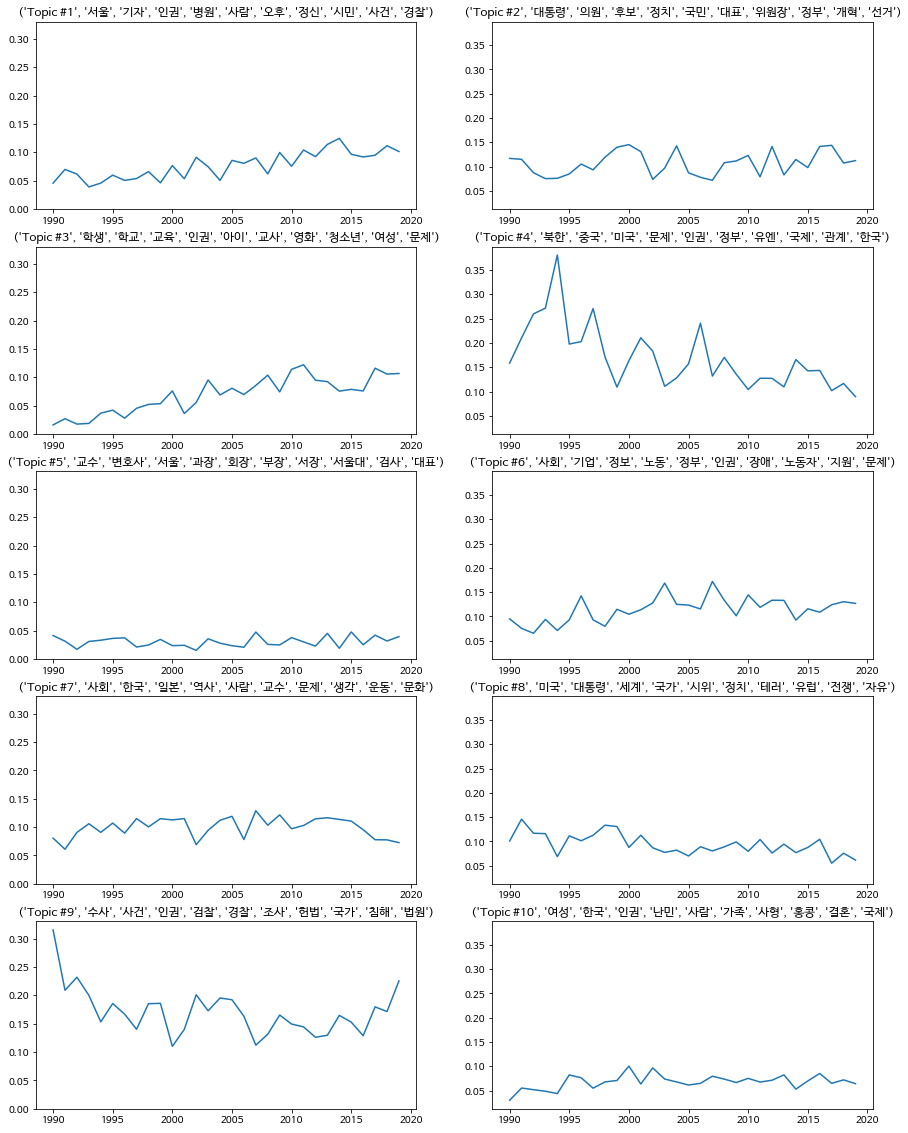

In [23]:
fig, axes = plt.subplots(figsize=(15,20), nrows=5, ncols=2, sharey='col') # y축의 묶음값을 공유한다?  
row = 0; col = 0; cnt = 0

x_values = ["Topic 01", "Topic 02", "Topic 03", "Topic 04", "Topic 05", "Topic 06", "Topic 07", "Topic 08", "Topic 09", "Topic 10"]
temp = pd.pivot_table(test, values=x_values, index="year", aggfunc="mean")

for i in range(mdl.k): 
    axes[row, col].plot(temp.index, temp[x_values[i]])   #topic0...부터 순서대로 하나씩 그린다..     
    axes[row, col].set_title(('Topic #{}'.format(i+1), *(w for w, _ in mdl.get_topic_words(i, top_n=10))), fontsize=12) # 단어와 확률값 2개를 리턴...1개만 받으면 오류... _ 에 해당하는 것이 확률값인데....보여주지 말아라(값을 무시하고 싶을때)
        
    if(col == 1): col = 0
    else: col = 1
    cnt += 1 # cnt = cnt+1
    if(cnt % 2 == 0): row += 1 # row = row+1

plt.show()

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fb1e9ec62d0>,
      dtype=object)

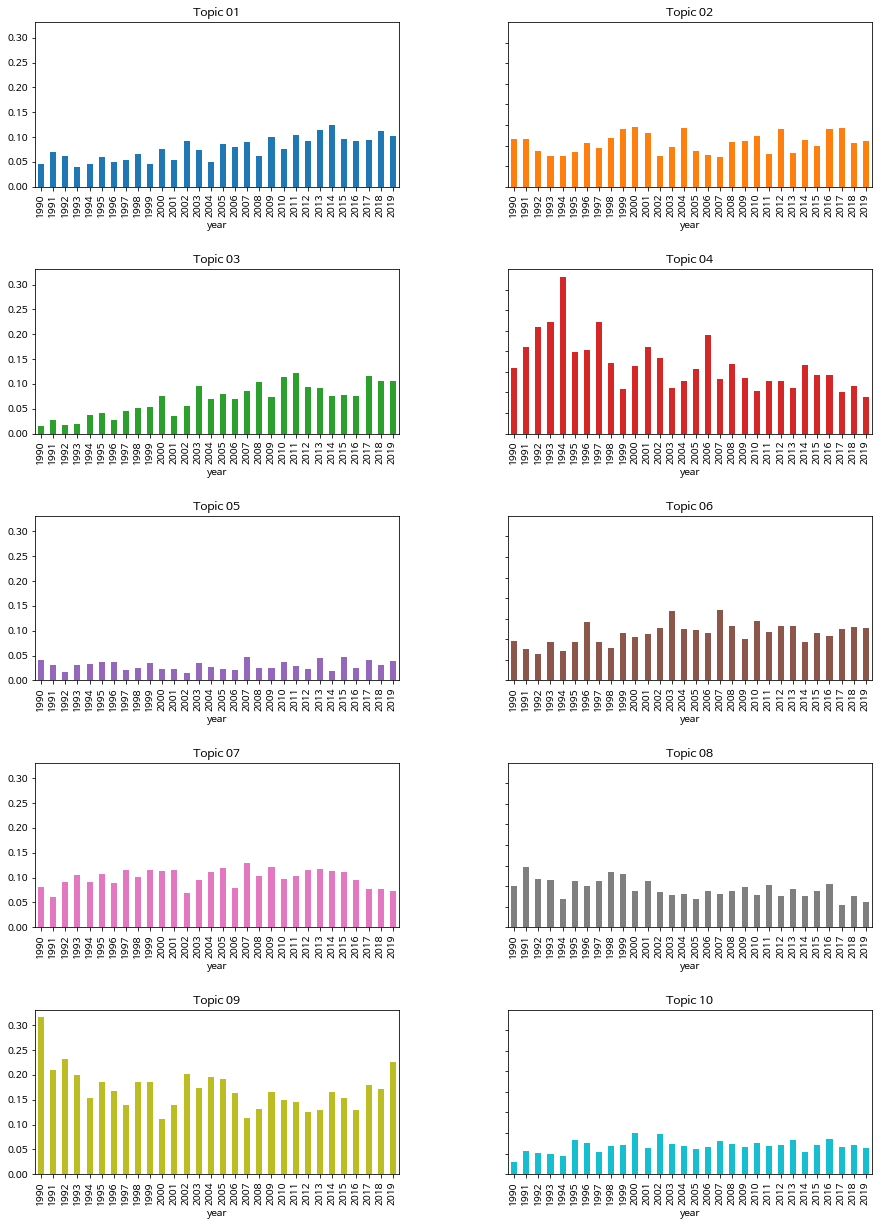

In [24]:
fig, ax = plt.subplots(figsize=(15,20), nrows=5, ncols=2, sharey='col') #sharey='col'은 그래프의 축을 결정해 주는 것....값이 입력이 들어가면 indexing을 연도...토픽값....y축을 share하고...col은 세로로 나온 값들을 지칭...

plt.subplots_adjust(left=0.125,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.3, 
                    hspace=0.5)

pd.pivot_table(test, values=["Topic 01", "Topic 02", "Topic 03", "Topic 04", "Topic 05", "Topic 06", "Topic 07", "Topic 08", "Topic 09", "Topic 10"],
               index="year", aggfunc="mean")\
               .plot(kind='bar', rot=90, ax=ax, subplots=True, legend=None) #년도별로 각토픽값을 평균내는 것...legend는 꺼두고....

In [25]:
test_mean = test.groupby(['year','group']).sum() #test로 만들어 놓은 것을 신문사와 연도별로 나눠서....
test_mean['Mean'] = test_mean.mean(axis=1)
test_mean.head()

Topic 01  Topic 02  Topic 03  ...  Topic 09  Topic 10  Mean
year group                                     ...                          
1990 Chosun      0.230723  1.074910  0.048916  ...  2.335679  0.215405   1.0
     Hankyoreh   0.567154  1.867526  0.063924  ...  6.330470  0.397027   1.5
     Joongang    0.882483  0.917913  0.614526  ...  2.900626  0.444789   1.3
     Kyunghyang  0.554806  1.866194  0.054519  ...  3.894654  0.418336   1.1
1991 Chosun      0.475844  1.096727  0.337024  ...  1.876004  0.322819   1.1

[5 rows x 11 columns]

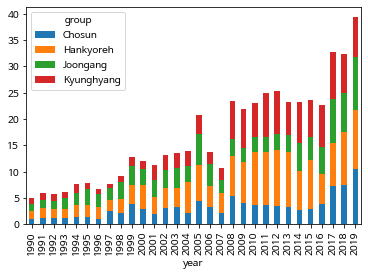

In [26]:
# 연도별+신문사별 토픽값의 평균

topic_group = test_mean.groupby(['year','group']).mean()['Mean']\
    .unstack('group')\
    .plot.bar(rot = 90, stacked=True)  # 스택을 풀어줄 인덱싱 부분이 group(신문사 부분)
                                       # stack=True를 안해 주면 연도별로 신문사가 따로 배치되므로, 해줘야 함

In [27]:
test.groupby(['year', 'group']).mean().unstack(level=1)

Topic 01                      ...  Topic 10                     
group    Chosun Hankyoreh  Joongang  ... Hankyoreh  Joongang Kyunghyang
year                                 ...                               
1990   0.023072  0.037810  0.067883  ...  0.026468  0.034215   0.038031
1991   0.043259  0.082790  0.086239  ...  0.018503  0.052014   0.131855
1992   0.019405  0.030671  0.082245  ...  0.055528  0.042320   0.061409
1993   0.058623  0.042332  0.018083  ...  0.080771  0.061136   0.004306
1994   0.037838  0.050551  0.043474  ...  0.034598  0.029949   0.045064
1995   0.069507  0.069486  0.058651  ...  0.063581  0.103478   0.068392
1996   0.076996  0.041984  0.063003  ...  0.046893  0.094522   0.101444
1997   0.069839  0.074934  0.025771  ...  0.055622  0.064234   0.027169
1998   0.084659  0.062689  0.055998  ...  0.043129  0.096394   0.036108
1999   0.051591  0.027245  0.053273  ...  0.039062  0.070830   0.066810
2000   0.067044  0.082324  0.076505  ...  0.093027  0.111605   0.077728
2001   0.026725  0.049524  0.075907  ...  0.064940  0.068441   0.055291
2002   0.121717  0.092985  0.109130  ...  0.105407  0.112047   0.067872
2003   0.071732  0.087068  0.068360  ...  0.064862  0.070792   0.092372
2004   0.066816  0.035226  0.062250  ...  0.058175  0.062727   0.075465
2005   0.076688  0.104196  0.087376  ...  0.074921  0.053645   0.060357
2006   0.074683  0.111675  0.049087  ...  0.067830  0.069457   0.049432
2007   0.101395  0.122238  0.051932  ...  0.069111  0.071039   0.101222
2008   0.053622  0.063958  0.060025  ...  0.067970  0.061096   0.075127
2009   0.075249  0.113176  0.073872  ...  0.060000  0.109763   0.058335
2010   0.071477  0.075740  0.069820  ...  0.076400  0.056137   0.074883
2011   0.108946  0.124869  0.078189  ...  0.057305  0.082768   0.068407
2012   0.050222  0.115204  0.096524  ...  0.067291  0.089033   0.066164
2013   0.084988  0.124874  0.100587  ...  0.074920  0.129772   0.046653
2014   0.118584  0.107882  0.142000  ...  0.043548  0.057597   0.048036
2015   0.121933  0.107163  0.064939  ...  0.059414  0.073727   0.079257
2016   0.045537  0.136212  0.052234  ...  0.061205  0.085602   0.096208
2017   0.065167  0.123430  0.103262  ...  0.064022  0.056103   0.062375
2018   0.106768  0.132208  0.099992  ...  0.068762  0.054540   0.086827
2019   0.084287  0.135007  0.079458  ...  0.061111  0.056820   0.073187

[30 rows x 40 columns]

In [28]:
test.groupby(['year', 'group']).mean()

Topic 01  Topic 02  Topic 03  ...  Topic 08  Topic 09  Topic 10
year group                                     ...                              
1990 Chosun      0.023072  0.107491  0.004892  ...  0.094423  0.233568  0.021541
     Hankyoreh   0.037810  0.124502  0.004262  ...  0.083654  0.422031  0.026468
     Joongang    0.067883  0.070609  0.047271  ...  0.130169  0.223125  0.034215
     Kyunghyang  0.050437  0.169654  0.004956  ...  0.094824  0.354059  0.038031
1991 Chosun      0.043259  0.099702  0.030639  ...  0.110496  0.170546  0.029347
...                   ...       ...       ...  ...       ...       ...       ...
2018 Kyunghyang  0.099897  0.124950  0.139346  ...  0.073687  0.162054  0.086827
2019 Chosun      0.084287  0.109649  0.101581  ...  0.073479  0.231372  0.068674
     Hankyoreh   0.135007  0.087980  0.111792  ...  0.046636  0.210420  0.061111
     Joongang    0.079458  0.156247  0.092993  ...  0.058267  0.251233  0.056820
     Kyunghyang  0.105190  0.092482  0.124654  ...  0.071590  0.204702  0.073187

[120 rows x 10 columns]

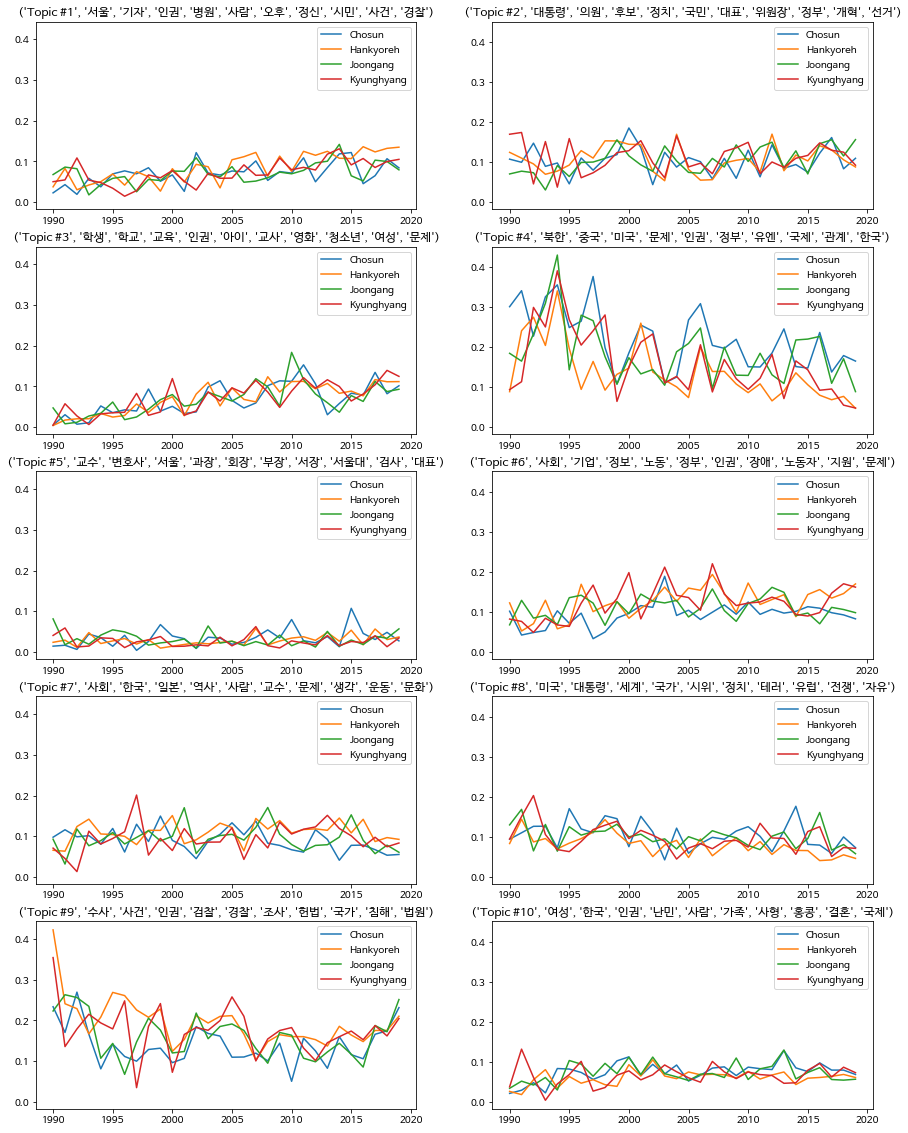

In [29]:
fig, axes = plt.subplots(figsize=(15,20), nrows=5, ncols=2, sharey='col')
row = 0; col = 0; cnt = 0

temp = test.groupby(['year', 'group']).mean().unstack(level=1)
x_values = ["Topic 01", "Topic 02", "Topic 03", "Topic 04", "Topic 05", "Topic 06", "Topic 07", "Topic 08", "Topic 09", "Topic 10"]
      
for i in range(mdl.k): 
    axes[row, col].plot(temp.index.get_level_values(0), temp[x_values[i]])      
    axes[row, col].set_title(('Topic #{}'.format(i+1), *(w for w, _ in mdl.get_topic_words(i, top_n=10))), fontsize=12)
    axes[row, col].legend(['Chosun', 'Hankyoreh', 'Joongang', 'Kyunghyang'])
        
    if(col == 1): col = 0
    else: col = 1
    cnt += 1 
    if(cnt % 2 == 0): row += 1

plt.show()

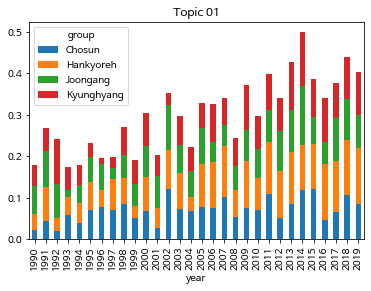

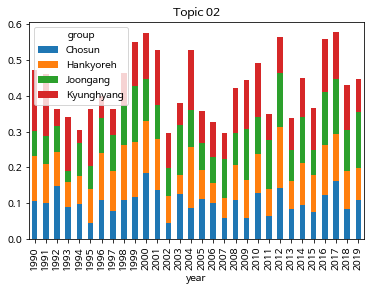

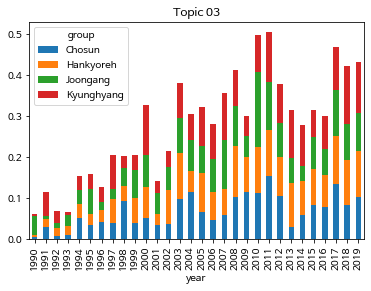

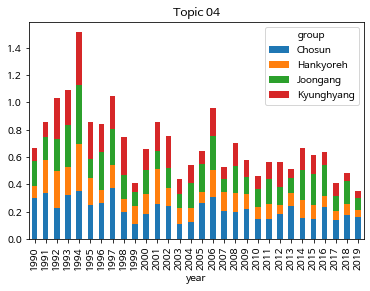

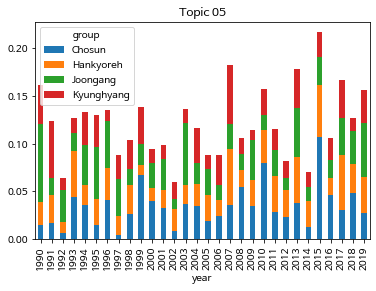

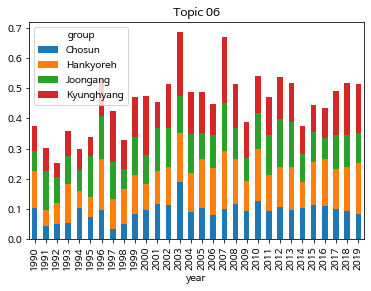

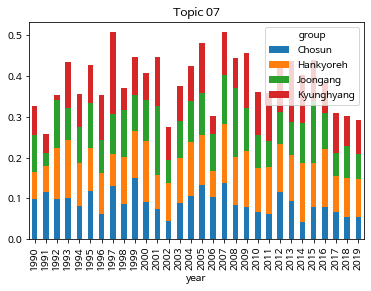

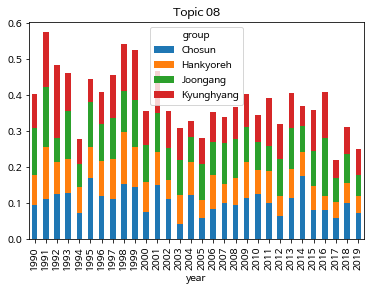

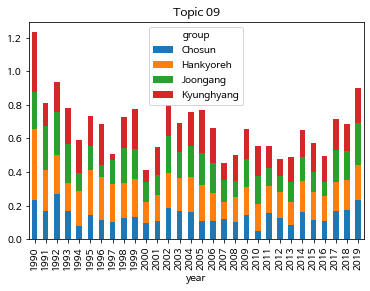

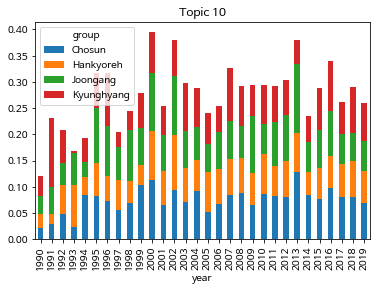

In [30]:
topic = list(["Topic 0" + str(i) if i < 10 else "Topic " + str(i) for i in range(1, 11)]) # list 안에는 명칭을 넣어준다....Topic 0으로 넣어야 Topic 01이 1로 나옴....str(i) i를 문자로 인식한다...
                                                                                          # 숫자, 문자 같이 넣어줄때, 숫자를 리스트로 바꿔줘야 함....

for i in topic:
    test.groupby(['year', 'group']).mean()[i].unstack(level='group').plot.bar(rot = 90, stacked=True, title=(i)) # 각 토픽별로 연도별 신문사 토픽값의 총계를 stacked bar 형태로 제시함